# **P**rincipal **O**rthogonal **L**atent **C**omponents **A**nalysis Net (POLCA-Net)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ipywidgets as widgets
import matplotlib.pyplot as plt

In [3]:
import scienceplots
from IPython.display import display, Markdown

type(scienceplots)
plt.style.use(["science", "no-latex"])

# Query the current default figure size
current_fig_size = plt.rcParams["figure.figsize"]
print(f"Current default figure size: {current_fig_size}")

# Define a scalar factor
scalar_factor = 1.5

# Multiply the current figure size by the scalar factor
new_fig_size = [size * scalar_factor for size in current_fig_size]

# Set the new default figure size
plt.rcParams["figure.figsize"] = new_fig_size

print(f"New default figure size: {new_fig_size}")

Current default figure size: [3.5, 2.625]
New default figure size: [5.25, 3.9375]


In [4]:
import numpy as np
import torch
import torchinfo
from sklearn import datasets

In [5]:
from polcanet import LinearDecoder, PolcaNet
from polcanet.example_aencoders import DenseEncoder

In [6]:
import polcanet.polcanet_reports as report

In [7]:
import random

import utils as ut

random_seed = 5
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)

torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

exp = ut.ExperimentInfoHandler(
    name="digits_dataset_8_components",
    description="POLCA-Net on digits dataset",
    random_seed=random_seed,
)
report.set_save_fig(True)
report.set_save_path(str(exp.get_experiment_folder()))
print(f"Saving Images: {report.get_save_fig()}, saving in path: {report.get_save_path()}")

Saving Images: True, saving in path: /data/deploy/polcanet/examples/notebooks/digits_dataset_8_components


### Load dataset

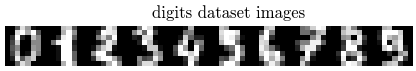

In [8]:
digits = datasets.load_digits()
X = digits.data / 255
y = digits.target
images = X.reshape(X.shape[0], 8, 8)
ut.plot_train_images(images, "digits dataset images", n=10)

### Fit standard sklearn PCA

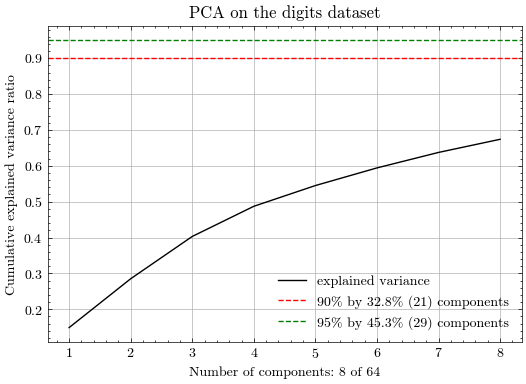

In [9]:
n_components = 8
fig, axs = plt.subplots(1, 1, sharex=True, sharey=True, layout="constrained")
pca = ut.get_pca(X, ax=axs, title="PCA on the digits dataset", n_components=n_components)
plt.show()
Xpca = pca.transform(X)

### Fit POLCANet

In [10]:
ae_input = X
act_fn = torch.nn.SiLU
input_dim = (ae_input.shape[1],)
latent_dim = pca.n_components

encoder = DenseEncoder(
    input_dim=input_dim,
    latent_dim=latent_dim,
    num_layers=3,
    act_fn=act_fn,
    first_layer_size=256,
    # hidden_size=512,
)

decoder = LinearDecoder(
    latent_dim=latent_dim,
    input_dim=input_dim,
    hidden_dim=256,
    num_layers=3,
    act_fn=act_fn,
    bias=True,
)

model = PolcaNet(
    encoder=encoder,
    decoder=decoder,
    latent_dim=latent_dim,
    alpha=1.0,  # ortgogonality loss
    beta=1.0,  # variance sorting loss
    gamma=0.0,  # variance reduction loss
    device="cuda",
    center=True,
    factor_scale=True,
)
print(model)
summary = torchinfo.summary(
    model,
    (1, input_dim[0]),
    dtypes=[torch.float],
    verbose=1,
    col_width=16,
    col_names=["kernel_size", "output_size", "num_params"],
    row_settings=["var_names"],
)
report.save_text(str(model),"model.txt")
report.save_text(str(summary),"model_summary.txt")

PolcaNet(
  (encoder): EncoderWrapper(
    (encoder): DenseEncoder(
      (encoder): Sequential(
        (0): Linear(in_features=64, out_features=256, bias=True)
        (1): SiLU()
        (2): Linear(in_features=256, out_features=194, bias=True)
        (3): SiLU()
        (4): Linear(in_features=194, out_features=132, bias=True)
        (5): SiLU()
        (6): Linear(in_features=132, out_features=70, bias=True)
        (7): SiLU()
        (8): Linear(in_features=70, out_features=8, bias=True)
      )
    )
  )
  (decoder): LinearDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=8, out_features=256, bias=True)
      (1): SiLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): SiLU()
      (4): Linear(in_features=256, out_features=64, bias=True)
    )
  )
  (polcanet_loss): PolcaNetLoss()
)
Layer (type (var_name))                  Kernel Shape     Output Shape     Param #
PolcaNet (PolcaNet)                      --               [1, 8]       

In [11]:
model.to("cuda")
model.train_model(data=X, batch_size=512, num_epochs=10000, report_freq=10, lr=1e-3)

epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Final metrics at epoch: 10000
Total Loss: 0.005151
Reconstruction Loss: 0.0001237
Orthogonality Loss: 0.002777
Center of Mass Loss: 0.001092
Variance Distribution Loss: 0


0.0051512939389795065

In [12]:
model.train_model(data=X, batch_size=512, num_epochs=5000, report_freq=10, lr=1e-4)

epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Final metrics at epoch: 5000
Total Loss: 0.001559
Reconstruction Loss: 0.0001197
Orthogonality Loss: 0.0007632
Center of Mass Loss: 0.000342
Variance Distribution Loss: 0


0.0015593363204970956

In [13]:
model.train_model(data=X, batch_size=512, num_epochs=5000, report_freq=10, lr=1e-5)

epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Final metrics at epoch: 5000
Total Loss: 0.001025
Reconstruction Loss: 0.000131
Orthogonality Loss: 0.0005249
Center of Mass Loss: 0.0001708
Variance Distribution Loss: 0


0.0010246204765280709

## Evaluate results

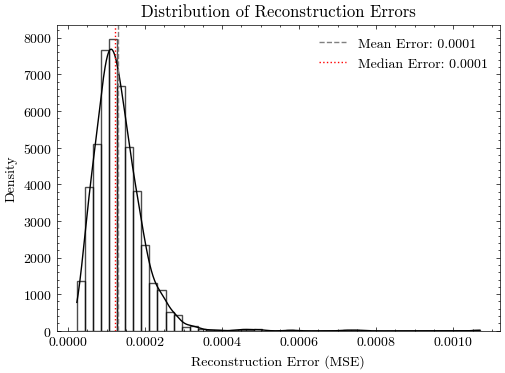

Mean Reconstruction Error: 0.0001
Median Reconstruction Error: 0.0001
Min Reconstruction Error: 0.0000
Max Reconstruction Error: 0.0011


In [14]:
report.analyze_reconstruction_error(model, X)

In [15]:
latents, reconstructed = model.predict(X)

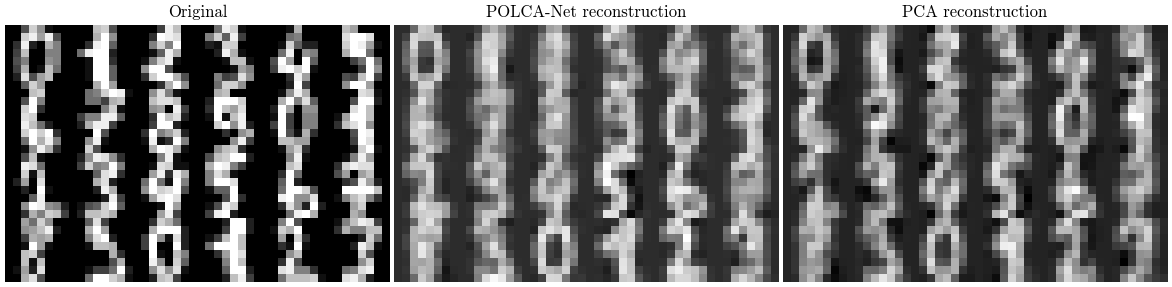

In [16]:
# Assuming images are properly defined as before
N = 24
images_to_show = images[:N]
# Reconstruct and visualise the images using the autoencoder
_, ae_reconstructed = model.predict(X[:N])
ae_reconstructed = ae_reconstructed.reshape(images_to_show.shape)
# Reconstruct and visualize the imagaes by PCA
pca_latents = pca.transform(X[:N])
pca_reconstructed = pca.inverse_transform(pca_latents)
pca_reconstructed = pca_reconstructed.reshape(images_to_show.shape)

ut.visualise_reconstructed_images(
    [images_to_show, ae_reconstructed, pca_reconstructed],
    title_list=["Original", "POLCA-Net reconstruction", "PCA reconstruction"],
    cmap="gray",
    nrow=6,
)


    Orthogonality Test Analysis

    This report analyzes the orthogonality of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The orthogonality of the features is assessed by minimizing the cosine distance between the 
    latent features. The cosine similarity values between the features are summarized below:

    - Mean cosine similarity: -0.0028
    - Max cosine similarity: 0.0154
    - Min cosine similarity: -0.0285
    


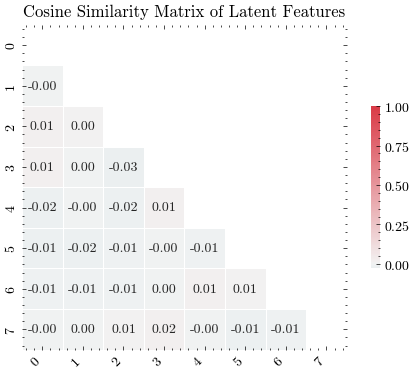

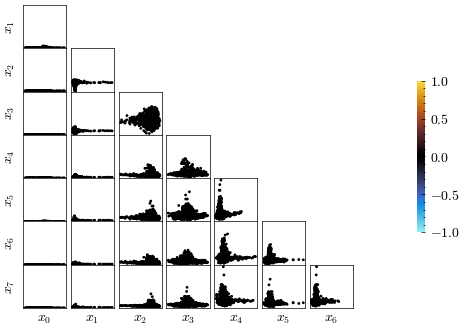

In [17]:
report.orthogonality_test_analysis(model, X)


    Variance Test Analysis

    This report analyzes the variance concentration of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The variance concentration of the features is assessed by minimizing the center of mass of the 
    latent space and fitting the variance distribution to an exponential distribution. The results 
    are summarized below:

    - Center of mass: 1.0022
    - Variance fit to exponential distribution (sum of squared differences):
     0.1964
    


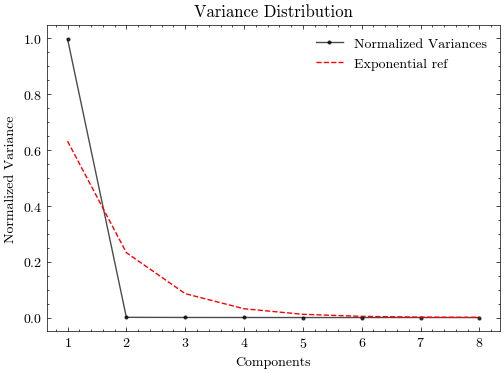

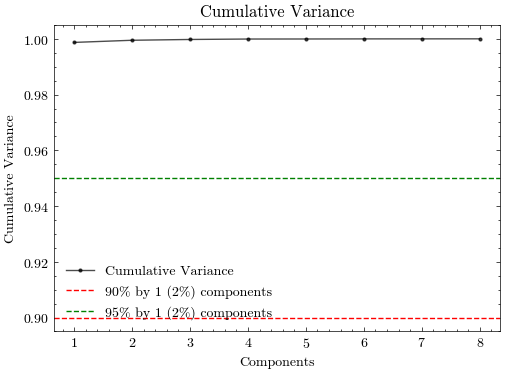

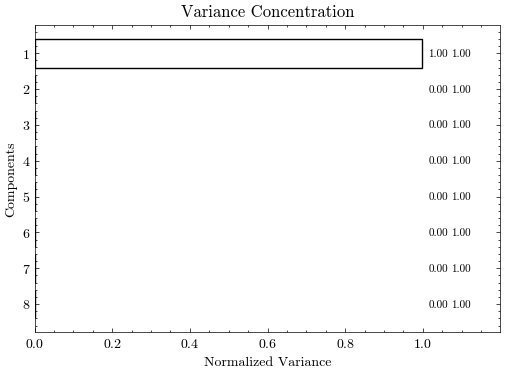

In [18]:
report.variance_test_analysis(model, X)

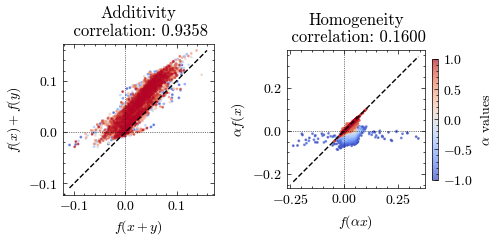

In [19]:
report.linearity_tests_analysis(model, X)

## Polca Net vs. PCA

In [20]:
o1 = widgets.Output()
o2 = widgets.Output()
with o1:
    _, _ = ut.plot2d_analysis(Xpca, y, title="PCA transform", legend=True)
with o2:
    _, _ = ut.plot2d_analysis(latents, y, title="POLCA-Net latent", legend=True)

layout = widgets.Layout(grid_template_columns="repeat(2, 600px)")
accordion = widgets.GridBox(children=[o1, o2], layout=layout)
display(accordion)

GridBox(children=(Output(), Output()), layout=Layout(grid_template_columns='repeat(2, 600px)'))

## Test Classification with two components on PCA vs POLCA Net

In [21]:
_ = ut.make_classification_report(model, pca, X, y)

(1257, 8) (540, 8)
(1257, 8) (540, 8)
Performance Metrics DataFrame:


/data/conda/envs/python3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/conda/envs/python3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/conda/envs/python3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Accuracy           Precision              Recall  \
Transformation             PCA     POLCA       PCA     POLCA       PCA   
Classifier                                                               
Gaussian Naive Bayes  0.861111  0.631481  0.866776  0.697756  0.861111   
Linear SVM            0.905556  0.733333  0.909331  0.778578  0.905556   
Logistic Regression   0.851852  0.687037  0.857367  0.750401  0.851852   
Perceptron            0.759259  0.585185  0.860092  0.611874  0.759259   
Ridge Classifier      0.812963  0.570370  0.817767  0.749682  0.812963   

                                F1-Score            
Transformation           POLCA       PCA     POLCA  
Classifier                                          
Gaussian Naive Bayes  0.631481  0.862104  0.622764  
Linear SVM            0.733333  0.906228  0.725117  
Logistic Regression   0.687037  0.852770  0.677323  
Perceptron            0.585185  0.733223  0.512597  
Ridge Classifier      0.570370  0.808361  0.551069


Wilcoxon Signed-Rank Test Results DataFrame:


,Wilcoxon Test Statistic,P-Value,Significant (p < 0.05)
Accuracy,0.0,0.0625,No better method
Precision,0.0,0.0625,No better method
Recall,0.0,0.0625,No better method
F1-Score,0.0,0.0625,No better method


In [22]:
experiment_data = {
    "digits": (
        images,
        model,
        pca,
    ),
}
_ = ut.image_metrics_table(experiment_data)

,Normalized Mean Squared Error,Peak Signal-to-Noise Ratio,Structural Similarity Index
Method,,,
POLCA digits,0.1448,87.4309,1.0
PCA digits,0.1044,88.7373,1.0
